# Compilation
Compile destination C file.  
Input: name of file without extension format
Output: finished / failed

In [1]:
import os
import sys
def compileCode(filename):
    os.system('gcc source_princetonlibgloballib/'+filename+'.c -lm -o '+filename)
    after_name = filename+".exe"
    print("Blackbox Model Name: ",filename)
    if(os.path.exists(after_name)):
        print("Compilation finished")
    else:
        print("Compilation failed")

# Read boundaries, starting points and number of variables
Read parameters from files in problemdata/ directory  
input: data file name without extension format
output: number of variables, lower bound, upper bound and starting point

In [2]:
def read_datafile(filename):
    numOfVar = 0
    lowBound = []
    upBound = []
    startPoint = []
    
    infile = open("problemdata/"+filename+".problem.data",'r')
    lines = infile.readlines()
    # The first line
    for num in lines[0].split():
        numOfVar = int(num.strip())
    # The second line
    for i in lines[1].split():
        lowBound.append(float(i.strip()))
    # The third line
    for j in lines[2].split():
        upBound.append(float(j.strip()))
    # The fourth line
    for k in lines[3].split():
        startPoint.append(float(k.strip()))
    infile.close()
    print("Number of Variables: ",numOfVar)
    print("Lower Boundary: ",lowBound)
    print("Upper Boundary: ",upBound)
    print("Starting point is: ",startPoint)
    return numOfVar,lowBound,upBound,startPoint

# Sampling
## Hammersley sequence
Generate input values according to Hammersley sequence which is a classical low discrepency sequence making points spread evenly in multi-dimentional space  
@Parameters:  
Input, integer I, the index of the element of the sequence.  0 <= I.    
Input, integer M, the spatial dimension.  1 <= M <= 100.  
Input, integer N, the "base" for the first component.   1 <= N.  
Output, real R(M), the element of the sequence with index I.

## Van der Corput sequence

## The Halton Quasi Monte Carlo (QMC) Sequence

Parameters:
    Input, integer I, the index of the element of the sequence.  
    0 <= I.  
    Input, integer M, the spatial dimension.  
    1 <= M <= 1600.  
    Output, real R(M), the element of the sequence with index I.

## Latin Random Squares in M dimensions

# Generate output values
@Parameters  
filename: name of black box model without extension  
variables: values of variables, in list format  
sequence: low discrepency sequence above, in list format  
index: index of the unfixed variable

In [5]:
def write_input(filename,input_values):
    infile = open(filename, 'w')
    for val in input_values:
        infile.write(str(val)+'\n')
    infile.close()
def read_output(filename,output_values):
    readfile = open(filename, 'r')
    for line in readfile.readlines():
        output_values.append(float(line.strip()))
    readfile.close()
def generate_bbox_values(filename,variables,sequence,index):
    input_filename = "input.in"
    output_filename = "output.out"
    output_values = []
    for val in sequence:
        input_copy = variables[:]
        input_copy[index] = val
        write_input(input_filename,input_copy)
        os.system('.\\'+filename)
        read_output(output_filename,output_values)
    return output_values

def check_bbox_optimal(filename,coordinate):
    input_filename = "input.in"
    output_filename = "output.out"
    output_values = []
    write_input(input_filename,coordinate)
    os.system('.\\'+filename)
    read_output(output_filename,output_values)
    return output_values[0]

# Regression
Use alamopy package to get the numerical expression  
@Parameters  
input_values:  
output_values:  
lowerBound: only a number  
upperBound: same as above 

In [6]:
import alamopy
from sklearn.model_selection import train_test_split
def call_alamopy(input_values,output_values,lowerBound,upperBound):
    X_train,X_test,y_train,y_test=train_test_split(input_values,output_values,test_size=0.25)
    X_test = test_reformat(X_test)
#     print("X_train",X_train)
#     print("X_test",X_test)
#     print("y_train",y_train)
#     print("y_test",y_test)
    alamo_result = alamopy.alamo(xdata=X_train,zdata=y_train,xval=X_test,zval=y_test,xmin=lowerBound,xmax=upperBound,monomialpower=(1,2),multi2power=(1,2))
#     print("===============================================================")
#     print("ALAMO results")
#     print("===============================================================")
#     print("#Model expression: ",alamo_result['model'])
#     print("#Rhe sum of squared residuals: ",alamo_result['ssr'])
#     print("#R squared: ",alamo_result['R2'])
#     print("#Root Mean Square Error: ",alamo_result['rmse'])
#     print("---------------------------------------------------------------")
    labels = alamo_result['xlabels']
    expr = alamo_result['f(model)']
    return labels,expr
def test_reformat(x_test):
    test_x = []
    for ele in x_test:
        test_x.append([ele])
    return test_x

# Optimization
Call baron by pyomo to get optimal solution

In [8]:
from pyomo.environ import *
from pyomo.opt import SolverFactory
def boundary_dic(labels,startPoint,index,lb,ub):
    lowerBound = {}
    upperBound = {}
#     for (label,val) in zip(labels,startPoint):
#         lowerBound[label] = val
#     for (label,val) in zip(labels,startPoint):
#         upperBound[label] = val
    lowerBound[labels[0]] = lb[index]
    upperBound[labels[0]] = ub[index]
    return lowerBound,upperBound

def call_baron(labels,expr,lowerBound,upperBound,startPoint,index):
    model = ConcreteModel(name='cycle')
    lBound_dic,uBound_dic = boundary_dic(labels,startPoint,index,lowerBound,upperBound)
    def fb(model,i):
        return (lBound_dic[i],uBound_dic[i])
    model.A = Set(initialize=labels)
    model.x = Var(model.A,within=Reals,bounds=fb)
    
    def objrule(model):
        var_lst = []
        for var_name in model.x:
            var_lst.append(model.x[var_name])
        return expr(var_lst)
    model.obj = Objective(rule=objrule,sense=minimize)
    opt = SolverFactory('baron')
    solution = opt.solve(model)
#     solution.write()
#     model.pprint()
#     model.display()
    
    obj_point = startPoint
    try:
        obj_point[index] = value(model.x[labels[0]])
        # print(value(model.x[labels[index]]))
    except:
        obj_point = startPoint
    obj_value = value(model.obj)
    return obj_point,obj_value

# updating step

In [11]:
def update_boundary(lowerBound, upperBound, startPoint, index, radius):
    new_lb = startPoint[:]
    new_ub = startPoint[:]
    # check if boundary after modification will be out of boundary
    if((startPoint[index] - radius) < lowerBound[index]):
        new_lb[index] = lowerBound[index]
    else:
        new_lb[index] = startPoint[index] - radius
    if((startPoint[index] + radius) > upperBound[index]):
        new_ub[index] = upperBound[index]
    else:
        new_ub[index] = startPoint[index] + radius
    return new_lb, new_ub

def update_status(optimal_val,box_val,optimal_point,startPoint,index,obj_lst,counter,counter_lst):
    if(box_val==0):
        box_val += 1e-5
    ratio = optimal_val / box_val
    if(ratio > 0.5 and ratio < 2):
        startPoint[index] = optimal_point[index]
        flag = 1.0
        # print("The point is updated")
        if(len(obj_lst)<1):
            obj_lst.append(box_val)
            counter_lst.append(counter)
            print("New optimal value is found: ",box_val)
        else:
            if(obj_lst[-1] > box_val):
                obj_lst.append(box_val)
                counter_lst.append(counter)
                print("New optimal value is found: ",box_val)
        if(len(obj_lst)>1 and (obj_lst[-2]-obj_lst[-1]<1e-5)):
            flag = "end"
    
        return flag
    else:
        # print("The point is not updated")
        flag = -1.0
        return flag
    
def update_radius(flag,radius,obj_lst):
    # box value does not match, decrease search radius
    if(flag == -1):
        radius = radius * 0.8
    # box value matches, increase search radius
    elif(flag == 1):
        if(len(obj_lst)>1 and obj_lst[-2]/obj_lst[-1]<10):
            radius = radius * 2
        elif(len(obj_lst)>1 and obj_lst[-2]/obj_lst[-1]>10):
            radius = radius * 1.2
        else:
            radius = radius * 1.5
    else:
        pass
    return radius


# Outport and plot

In [14]:
import matplotlib.pyplot as plt
def make_plot(values, calls, name):
    print("Optimal values: ",values)
    print("Number of calls: ", calls)
    plt.plot(calls, values, '-o')
    plt.xlabel("Number of calls")
    plt.ylabel("Optimal values")
    plt.title(name)
    plt.savefig("plots\\"+name+".png")
    print("Plot of model "+ name +" is saved")
    
from pandas import DataFrame
import csv
def make_csv(name,values,calls,time,points,cycle):
    csvfile = open('experimentData.csv','a+',newline='')
    fieldsnames = ['model_name','time','cycle','values','calls','point']
    # writer = csv.writer(csvfile,delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer = csv.DictWriter(csvfile,fieldnames=fieldsnames)
    # values = list_int2str(values)
    # calls = list_int2str(calls)
    # writer.writerow([name,calls[-1]]+values)
    if(len(points)>0):
        writer.writerow({
            'model_name':name,
            'time':time,
            'cycle':cycle,
            'values':values[-1],
            'calls':calls[-1],
            'point':points[-1]
        })
    else:
        writer.writerow({
            'model_name':name,
            'time':time,
            'cycle':cycle,
            'values':values[-1],
            'calls':calls[-1]
        })
    csvfile.close()

def list_int2str(lst):
    temp = []
    for i in range(len(lst)):
        temp.append(str(lst[i]))
    return temp    

# Core Algorithms

## Coordinate Search

In [56]:
import random
def coordinate_search(cycles,startPoint, lowerBound, upperBound):
    # Initialization
    radius = 1.0
    counter = 0
    obj_lst = []
    counter_lst = []
    optimal_point_lst = []
    for cycle in range(cycles):
        print("The cycle: ", cycle)
        shuffle_order = list(range(len(startPoint)))
        random.shuffle(shuffle_order)
        for indexOfVar in shuffle_order:
            # update boundary
            lb,ub = update_boundary(lowerBound,upperBound,startPoint,indexOfVar,radius)
            # generate sampling points sequence
#             Xdata = van_der_corput(lb[indexOfVar],ub[indexOfVar],20)
            Xdata = halton_sequence(lb[indexOfVar],ub[indexOfVar],20)
            # generate black box model values
            ydata = generate_bbox_values(compileFile,startPoint,Xdata,indexOfVar)
            # call alamopy to generate expression and labels of variables
            labels,expr = call_alamopy(Xdata,ydata,lb[indexOfVar],ub[indexOfVar])
            # call baron to optimize the function and see where do we get the opt value
            optimal_point,optimal_val = call_baron(labels,expr,lb,ub,startPoint,indexOfVar)
            optimal_point_lst.append(optimal_point)
            # check the qualification of regression
            box_val = check_bbox_optimal(compileFile,optimal_point)
            # update counter & counter list
            counter += 20
            # update flag status
            flag = update_status(optimal_val,box_val,optimal_point,startPoint,indexOfVar,obj_lst,counter,counter_lst)
            if(flag == "end"):
                print("Optimal value is found within requested iterations")
                return obj_lst, counter_lst,optimal_point_lst, cycle+1
            # update search radius
            radius = update_radius(flag, radius,obj_lst)
    return obj_lst, counter_lst, optimal_point_lst,cycles

## Block coordinate search

# main function
Integration of functions above

In [58]:
compileFile = "branin"
cycles = 10
compileCode(compileFile)
numOfVar, lowerBound, upperBound, startPoint = read_datafile(compileFile)
values, calls, point_lst, cycle = coordinate_search(cycles, startPoint, lowerBound, upperBound)

Blackbox Model Name:  branin
Compilation finished
Number of Variables:  2
Lower Boundary:  [-5.0, 0.0]
Upper Boundary:  [10.0, 15.0]
Starting point is:  [2.5, 7.5]
The cycle:  0
Calling ALAMO now:
New optimal value is found:  15.78702362332726
Calling ALAMO now:
The cycle:  1
Calling ALAMO now:
New optimal value is found:  5.90420310447853
Calling ALAMO now:
The cycle:  2
Calling ALAMO now:
Calling ALAMO now:
New optimal value is found:  2.976232296017698
The cycle:  3
Calling ALAMO now:
New optimal value is found:  1.233809443969236
Calling ALAMO now:
The cycle:  4
Calling ALAMO now:
Calling ALAMO now:
The cycle:  5
Calling ALAMO now:
Calling ALAMO now:
The cycle:  6
Calling ALAMO now:
Calling ALAMO now:
The cycle:  7
Calling ALAMO now:
Calling ALAMO now:
The cycle:  8
Calling ALAMO now:
Calling ALAMO now:
The cycle:  9
Calling ALAMO now:
Calling ALAMO now:


[15.78702362332726, 5.90420310447853, 2.976232296017698, 1.233809443969236]


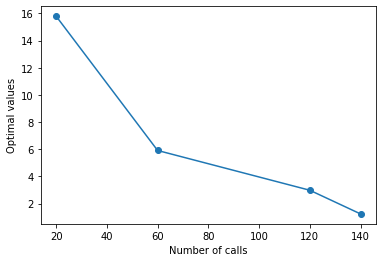

In [61]:
print(values)
plt.plot(calls, values, '-o')
plt.xlabel("Number of calls")
plt.ylabel("Optimal values")
plt.show()